In [1]:
import tensorflow as tf
import numpy as np
import importlib.util
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def load_module(path):
    spec = importlib.util.spec_from_file_location("module.name", path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module

def load_arch(arch_path):
    arch = load_module(arch_path)
    nn = arch.CNN()

    g = tf.Graph()
    with g.as_default():
        nn.create_architecture()
    return g, nn

In [3]:
graph, nn = load_arch("arch_invariant.py")

In [4]:
sess = tf.Session(graph=graph)

In [5]:
sess.run(tf.variables_initializer(graph.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)))

<IPython.core.display.Javascript object>


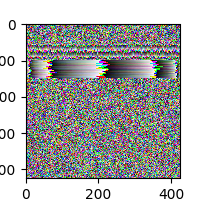

In [16]:
x = np.random.normal(size=(424, 424, 3))
x[50:100, :, :]  = np.sort(x[50:100, :, :], 0)
x[100:150, :, :] = np.sort(x[100:150, :, :], 1)
x[150:200, :, :] = np.sort(x[150:200, :, :], 2)
plt.figure(figsize=(2,2))
plt.imshow(x)

In [7]:
def dihedral(x, i):
    x = x.copy()
    if i & 4:
        x = np.transpose(x, (1, 0, 2))  # tau[4]
    if i & 1:
        x = x[:, ::-1, :]  # tau[1]
    if i & 2:
        x = x[::-1, :, :]  # tau[2]
    return x

In [8]:
xs = np.array([dihedral(x, i) for i in range(8)])

In [9]:
ps = sess.run(nn.tfp, feed_dict={nn.tfx: xs})
print(np.transpose(ps))

[[  6.20345771e-01   6.20344996e-01   6.20350182e-01   6.20347083e-01
    6.20346010e-01   6.20342195e-01   6.20348155e-01   6.20345116e-01]
 [  4.95572854e-03   4.95572900e-03   4.95580584e-03   4.95571736e-03
    4.95578442e-03   4.95574716e-03   4.95576346e-03   4.95577045e-03]
 [  3.74698520e-01   3.74699295e-01   3.74694020e-01   3.74697238e-01
    3.74698251e-01   3.74702096e-01   3.74696046e-01   3.74699205e-01]
 [  3.11952503e-03   3.11957137e-03   3.11959838e-03   3.11953854e-03
    3.11957370e-03   3.11955228e-03   3.11956694e-03   3.11958697e-03]
 [  1.83620362e-03   1.83615752e-03   1.83620723e-03   1.83617882e-03
    1.83621061e-03   1.83619466e-03   1.83619605e-03   1.83618325e-03]
 [  1.18715012e-04   1.18713273e-04   1.18714561e-04   1.18712022e-04
    1.18715514e-04   1.18715703e-04   1.18714481e-04   1.18713804e-04]
 [  1.71748863e-03   1.71744428e-03   1.71749259e-03   1.71746674e-03
    1.71749503e-03   1.71747897e-03   1.71748165e-03   1.71746942e-03]
 [  6.6470314

In [10]:
test = sess.run(nn.test, feed_dict={nn.tfx: xs})
test = np.reshape(test, (8, 8, -1))

<IPython.core.display.Javascript object>


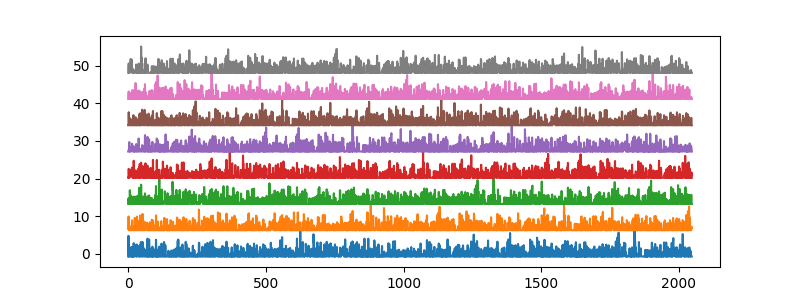

In [20]:
step = test[0].max() - test[0].min()
plt.figure(figsize=(8,3))
for i in range(8):
    plt.plot(test[i].flatten() + step * i)

<IPython.core.display.Javascript object>


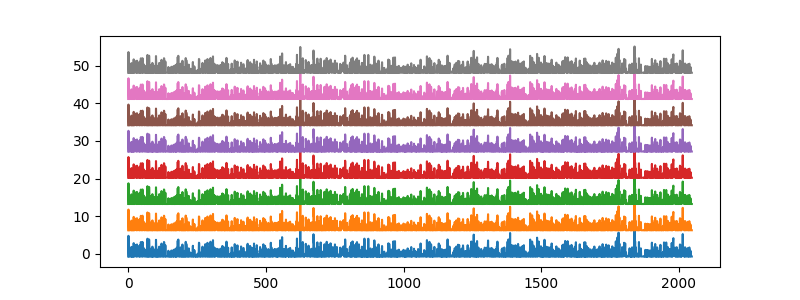

In [21]:
mt = np.array([ [0, 1, 2, 3, 4, 5, 6, 7], [1, 0, 3, 2, 5, 4, 7, 6],
                [2, 3, 0, 1, 6, 7, 4, 5], [3, 2, 1, 0, 7, 6, 5, 4],
                [4, 6, 5, 7, 0, 2, 1, 3], [5, 7, 4, 6, 1, 3, 0, 2],
                [6, 4, 7, 5, 2, 0, 3, 1], [7, 5, 6, 4, 3, 1, 2, 0]])
# tau[mt[a,b]] = tau[a] o tau[b]

iv = np.array([0, 1, 2, 3, 4, 6, 5, 7])
# tau[iv[a]] is the inverse of tau[a]

plt.figure(figsize=(8,3))
for i in range(8):
    plt.plot(test[i][mt[i]].flatten() + step * i)